In [1]:
import math
import os
import pathlib
import random
from datetime import datetime

import cv2
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from helpers import Compose
from visualizations import Visualizations

# from torchvision import transforms

vis = Visualizations()

# setting reprodutibilitty
# torch.manual_seed(0)
# np.random.seed(0)

# from fastai.vision import Image
# import torchaudio
# import matplotlib.pyplot as plt
# import pyrubberband as pyrb
# from torchsummary import summary

In [2]:
def languageToLabel(language):
    '''Troca a representação em string da classe para uma representação em int
    
        language: string
    '''

    if language == 'alemao':
        return 0
    elif language == 'ingles':
        return 1
    elif language == 'espanhol':
        return 2

tempo_inicio_treino = datetime.now()
def save_model(name):
    '''Pode ser usado para salvar parâmetros a cada epoch.'''
    
    tempo_formatado = tempo_inicio_treino.strftime("%d-%m-%Y-%H:%M:%S")
    folder_path = F'./data/pth_checkpoints/{tempo_formatado}'
    pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
    
    # somente os parâmetros
    save_path = folder_path + F'/{name}.pth'
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, save_path)

    # todo o modelo
    save_path_full = folder_path + F'/{name}_full.pth'
    torch.save(model, save_path_full)
    
def load_model(model, optimizer, full_path):
    
    checkpoint = torch.load(full_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [3]:
class MeuDataset(Dataset):
    '''Inicialização

    Nota que devemos croppar para 220500 p/ aumentar o batch size.
    '''
    def __init__(self, rootPath, csvPath, transform=None):
        self.csvData = pd.read_csv(csvPath, delimiter=';')
        self.rootPath = rootPath
        self.list_IDs = self.csvData.iloc[:, 0]
        self.labels = self.csvData.iloc[:, 1]
        self.transform = transform

    def __len__(self):
        '''Número total de amostras'''
        return self.csvData.shape[0]

    def __getitem__(self, index):
        'Gera uma amostra da lista'
        # Carrega a amostra e pega a label
        X = librosa.load(self.rootPath + self.list_IDs[index])
        y = languageToLabel(self.labels[index])

        audio_sample = {}
        audio_sample['sample_array'], audio_sample['sample_rate'] = X

        # croppamos os que não estão no padrão
        audio_sample['sample_array'] = audio_sample['sample_array'][:220500]

        if self.transform:
            X = self.transform(audio_sample)

        return X, y

    @staticmethod
    def get_mean_std(dataloader):
        '''
        Iterates through batches and extract its mean and std dev.
        This is supposed to run only once, and then hard code the results into the normalization step.
        
        Params:
            loader: Dataloader object
        
        Returns:
            tuple of mean and standard deviation of all examples in dataloader
        
        '''

        mu = 0
        sigma = 0
        nb_samples = 0
        current_batch = 1
        for images_list, labels in dataloader:

            batch_samples = images_list.size(0)
            #             print(images_list.size())

            flatenned_spectrograms = images_list.view(batch_samples,
                                                      images_list.size(1), -1)
            #             print(flatenned_spectrograms.size())

            mu += flatenned_spectrograms.mean(2).sum(0)
            sigma += flatenned_spectrograms.std(2).sum(0)

            #             print(mu.size())
            #             print(sigma.size())

            nb_samples += batch_samples
            current_batch += 1
            print(current_batch)

        mu = mu / nb_samples
        sigma = sigma / nb_samples

        return mu, sigma

    @property
    def classes(self):
        return self.labels.unique()

In [4]:
# transformations
class ToSpectrogram(object):
    '''Convert audio sample to Mel-Spectrogram and resize it, multiplying its size to a number'''
    def __init__(self, multiply_by):
        '''Multiply spectrogram size by number

        multiply_by: int

        '''

        self.multiply_by = multiply_by

    def __call__(self, audio_sample):
        '''Convert audio to mel-spectrogram and then resizes it'''

        audio_sample_array, sample_rate = audio_sample[
            'sample_array'], audio_sample['sample_rate']

        # setar para escala mel
        S = librosa.feature.melspectrogram(audio_sample_array,
                                           sr=sample_rate,
                                           n_mels=128,
                                           n_fft=1024,
                                           hop_length=256,
                                           fmin=0.0,
                                           fmax=None)

        # arrumar amplitude
        S = librosa.amplitude_to_db(S, ref=np.min, amin=1e-05, top_db=120.0)

        new_H = S.shape[0] * self.multiply_by
        new_W = S.shape[1] * self.multiply_by

        resized_spectrogram = cv2.resize(S,
                                         dsize=(new_W, new_H),
                                         interpolation=cv2.INTER_CUBIC)

        return resized_spectrogram


class ToTensor(object):
    """Convert ndarrays in sample to Tensors.

    object: np.array
    """
    def __call__(self, spectrogram):
        '''Insert dimension of size one at first position'''

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        return torch.from_numpy(spectrogram).unsqueeze(0)


class Normalize(object):
    '''Normalizes tensors by subtracting by its mean, and dividing by the std deviation
    
    object: tensor
    '''
    def __init__(self, stats):
        '''
        stats: tuple with (mean, std_dev)
        '''

        self.mean, self.std_dev = stats

    def __call__(self, tensor):

        return (tensor - self.mean) / self.std_dev

In [5]:
def init_weights(m):
    '''Initializing weights as described by Kaiming et al. '''
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)


class CRNN(nn.Module):
    '''Teste'''
    def __init__(self, H_W, nb_classes):
        '''H_W: tuple'''
        super(CRNN, self).__init__()

        self.H, self.W = H_W

        # time feature extraction
        self.conv1_time = nn.Conv2d(1,
                                    out_channels=32,
                                    kernel_size=(6, self.W - 1),
                                    padding=(0, 428),
                                    bias=False)
        self.bn1_time = nn.BatchNorm2d(32)
        self.relu1_time = nn.LeakyReLU(negative_slope=1e-2)
        self.maxpool_time = nn.MaxPool2d((8, 16))

        # frequency feature extraction
        self.conv1_freq = nn.Conv2d(1,
                                    out_channels=32,
                                    kernel_size=(self.H, 5),
                                    padding=(61, 0),
                                    bias=False)
        self.bn1_freq = nn.BatchNorm2d(32)
        self.relu1_freq = nn.LeakyReLU(negative_slope=1e-2)
        self.maxpool_freq = nn.MaxPool2d((8, 16))

        self.dense_layer = nn.Linear(64 * 15 * 53, nb_classes)
        # self.dense_layer = nn.Linear(64 * 61 * 429, nb_classes)
        # self.dense_layer = nn.Linear(32 * 125 * 1, nb_classes)

    def forward(self, x):
        '''Here we forward the spectrogram two times to a first-layer, then we concat
        these two first layers and we go through the forward propagation.

        '''

        x1 = x
        x2 = x

        x1 = self.conv1_time(x1)
        x1 = self.bn1_time(x1)
        x1 = self.relu1_time(x1)
        x1 = self.maxpool_time(x1)

        x2 = self.conv1_freq(x2)
        x2 = self.bn1_freq(x2)
        x2 = self.relu1_freq(x2)
        x2 = self.maxpool_freq(x2)

        # print("x1 shape: ", x1.shape)
        # print("x2 shape: ", x2.shape)

        x = torch.cat((x1, x2), dim=1)
        # print("after concat: ", x.shape)

        # flatten
        x = x.view(x.size(0), -1)

        #         print("after flatten: ", x.shape)

        x = self.dense_layer(x)
        x = F.log_softmax(x, dim=1)

        return x

In [6]:
def make_dataloader(dataset,
                    training_percentage,
                    batch_size,
                    debug=False,
                    debug_size=0.02):
    '''Split dataset into training_set and test_set
    
    Params:
        dataset: dataset
        training_percentage: float number between [0, 1] to split train/test set.
        
    Returns:
        training_loader, test_loader: DataLoader objects
    '''

    DEBUG_PERCENT_SIZE = debug_size

    dataset_length = len(dataset) if not debug else math.floor(
        len(dataset) * DEBUG_PERCENT_SIZE)
    training_set_size = math.floor(dataset_length * training_percentage)
    test_set_size = dataset_length - training_set_size

    if debug:
        print(F"Debug: {debug}\n"
              F"Dataset Length: {dataset_length}\n"
              F"Training Set Size: {training_set_size}\n"
              F"Test Set Size: {test_set_size}\n"
              F"Sanity Check: {training_set_size + test_set_size}")

    indices = np.random.permutation(len(dataset))
    training_idxs = indices[:training_set_size]
    test_idxs = indices[training_set_size:training_set_size + test_set_size]

    training_sampler = SubsetRandomSampler(training_idxs)
    test_sampler = SubsetRandomSampler(test_idxs)

    training_loader = DataLoader(dataset,
                                 batch_size=batch_size,
                                 num_workers=2,
                                 sampler=training_sampler,
                                 # pin_memory=True,
                                 drop_last=True)

    test_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2,
        sampler=test_sampler,
        # pin_memory=True,
        drop_last=True)
    

    return training_loader, test_loader

In [7]:
composed = Compose(
    [ToSpectrogram(1),
     ToTensor(), Normalize((35.8871, 23.5386))])

# (tensor([35.8871]), tensor([23.5386]))

dataset_training = MeuDataset(
    "./data/", "./data/spoken-language-identification/training.csv", composed)

dataset_test = MeuDataset("./data/",
                          "./data/spoken-language-identification/test.csv",
                          composed)

# librosa.display.specshow(a, y_axis='mel', fmax=8000, x_axis='time')
# Image.show(a, figsize=(20, 5), cmap=None, hide_axis=False)

In [8]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# is_cuda = 0

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [9]:
def train(model, dataloader, debug=False):
    '''
    
    '''

    model.train()
    vis.operation = 'Training'

    loss_history = []

    # step = # batch
    # data = batch contents
    # data[0] = tensors
    # data[1] = labels

    # running_loss = 0.0
    for step, data in enumerate(dataloader):

        # zero grad
        optimizer.zero_grad()

        # loading from data, and assigning to cuda
        inputs, labels = data
        if is_cuda:
            inputs = inputs.to(device)
            labels = labels.to(device)

        outputs = model(inputs).to(device)
        # print("outputs size:", outputs.shape)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        # statistics
        # running_loss += loss.item()
        loss_history.append(loss.item())

        vis.plot_current_batch(step, batch_size, len(dataloader) * batch_size)
        vis.update_elapsed_time()

        if step % 10 == 0:
            vis.plot_loss(np.mean(loss_history[-10:]), step, F"epoch_{epoch}")
            if debug:
                print(F'\nEpoch: {epoch}')
                print(
                    F'Samples: {step * batch_size} of {len(dataloader) * batch_size}'
                )
                print(F'Loss: {loss_history[-1]}\n')

    return loss_history


def evaluate(model, dataloader, debug=False):

    model.eval()
    vis.operation = 'Evaluation'

    correct = 0
    total = 0
    class_correct = [x for x in range(3)]
    class_total = [x for x in range(3)]

    labels_numpy = np.array([])
    predicted_numpy = np.array([])

    with torch.no_grad():

        for step, data in enumerate(dataloader):

            inputs, labels = data

            if is_cuda:
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()

            # statistics
            vis.plot_current_batch(step, batch_size,
                                   len(dataloader) * batch_size)
            vis.update_elapsed_time()

            #for i in range(batch_size):
            #label = labels[i]
            #class_correct[label] += c[i].item()
            #class_total[label] += 1

            if debug:
                print(F"\nTotal Examples: {len(dataloader) * batch_size}\n"
                      F"Correct: {correct} of {total}\n"
                      F"Labels: {labels}\n"
                      F"Predicted: {predicted}\n"
                      F"Classes Correct: {class_correct}"
                      F"Classes Total: {class_total}")

            labels_numpy = np.append(labels_numpy, labels.cpu().numpy())
            predicted_numpy = np.append(predicted_numpy,
                                        predicted.cpu().numpy())

    return labels_numpy, predicted_numpy

In [10]:
batch_size = 32
nb_classes = 3
nb_epochs = 10

eval_first = False

# training_loader, test_loader = make_dataloader(dataset_completo,
#                                      1.0,
#                                      batch_size,
#                                      debug=False,
#                                      debug_size=0.02)

training_loader, _ = make_dataloader(dataset_training,
                                     1.0,
                                     batch_size,
                                     debug=False,
                                     debug_size=0.01)

test_loader, _ = make_dataloader(dataset_test,
                                 1.0,
                                 batch_size,
                                 debug=False,
                                 debug_size=0.5)

model = CRNN((128, 862), nb_classes)
model.apply(init_weights)
learning_rate = 1e-3

if is_cuda:
    torch.cuda.empty_cache()
    model.cuda()

loss_fn = nn.NLLLoss()  #.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# load_model(model, optimizer, 2)

In [11]:
#summary(model, (1, 128, 862))
epoch_loss_history = []
epoch_eval_history = []
vis.epoch_total = nb_epochs

for epoch in range(nb_epochs):

    # stats
    vis.epoch_current += 1

    if not eval_first or epoch > 0:
        loss_history = train(model, dataloader=training_loader, debug=False)
        epoch_loss_history.append(loss_history)
        vis.plot_epoch_loss(epoch_loss_history)

    true_labels, predicted_labels = evaluate(model,
                                             dataloader=test_loader,
                                             debug=False)
    epoch_eval_history.append((true_labels, predicted_labels))

    # stats
    vis.plot_confusion_matrix(true_labels, predicted_labels)
    vis.plot_roc_auc_score(true_labels, predicted_labels, epoch)
    
    # save after each epoch
    save_model(F'epoch_{epoch + 1}')

vis.update_elapsed_time(isFinished=True)

Normalized confusion matrix
[[0.40116279 0.54069767 0.05813953]
 [0.         0.96449704 0.03550296]
 [0.         0.         1.        ]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.87058824 0.08823529 0.04117647]
 [0.05882353 0.91176471 0.02941176]
 [0.14534884 0.01162791 0.84302326]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.81065089 0.03550296 0.15384615]
 [0.10059172 0.76331361 0.13609467]
 [0.02873563 0.         0.97126437]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.38596491 0.33918129 0.2748538 ]
 [0.00584795 0.91812865 0.07602339]
 [0.         0.02352941 0.97647059]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.85714286 0.03571429 0.10714286]
 [0.         0.95953757 0.04046243]
 [0.04093567 0.01169591 0.94736842]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.88757396 0.04733728 0.06508876]
 [0.04093567 0.94736842 0.01169591]
 [0.10465116 0.02325581 0.87209302]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.92771084 0.02409639 0.04819277]
 [0.00578035 0.89595376 0.0982659 ]
 [0.02312139 0.         0.97687861]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.97674419 0.00581395 0.01744186]
 [0.0295858  0.9408284  0.0295858 ]
 [0.06432749 0.03508772 0.9005848 ]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.99408284 0.         0.00591716]
 [0.05813953 0.93023256 0.01162791]
 [0.20467836 0.01754386 0.77777778]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Normalized confusion matrix
[[0.98224852 0.00591716 0.01183432]
 [0.03550296 0.8816568  0.08284024]
 [0.09770115 0.00574713 0.89655172]]


/home/martin/Documentos/PythonEnvironments/tcc-py3.7/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


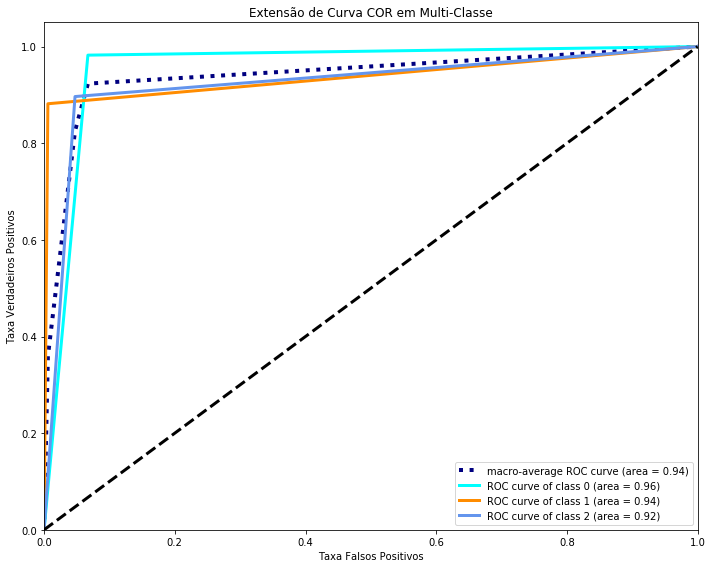

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer, label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

label_real = epoch_eval_history[9][0][:]
label_pred = epoch_eval_history[9][1][:]

lb = LabelBinarizer()
lb.fit(label_real)

label_real_binarizado = lb.transform(label_real)
label_pred_binarizado = lb.transform(label_pred)
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
f1_score_list = list()
for i in range(nb_classes):
    fpr[i], tpr[i], threshold = roc_curve(label_real_binarizado[:, i],
                                          label_pred_binarizado[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    f1_score_list.append(
        precision_recall_fscore_support(label_real_binarizado[:, i],
                                        label_pred_binarizado[:, i],
                                        average='macro'))

roc_auc_score(label_real_binarizado, label_pred_binarizado, average="macro")

# funcao plot roc
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
# plt.plot(fpr["micro"],
#          tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#          ''.format(roc_auc["micro"]),
#          color='deeppink',
#          linestyle=':',
#          linewidth=4)

lw = 3

plt.plot(fpr["macro"],
         tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["macro"]),
         color='navy',
         linestyle=':',
         linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i],
             tpr[i],
             color=color,
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falsos Positivos')
plt.ylabel('Taxa Verdadeiros Positivos')
plt.title('Extensão de Curva COR em Multi-Classe')
plt.legend(loc="lower right")
plt.show()

In [54]:
# save_model('epoch_10')

In [66]:
precision_recall_fscore_support(label_real_binarizado[:, 2], label_pred_binarizado[:, 2], average='macro')

(0.9270177838577291, 0.9246072230157111, 0.925793305710437, None)

In [74]:
roc_auc[2]

0.9246072230157111

In [76]:
# from torchsummary import summary
# summary(model, (1, 128, 862))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 123, 858]         165,312
       BatchNorm2d-2         [-1, 32, 123, 858]              64
         LeakyReLU-3         [-1, 32, 123, 858]               0
         MaxPool2d-4           [-1, 32, 15, 53]               0
            Conv2d-5         [-1, 32, 123, 858]          20,480
       BatchNorm2d-6         [-1, 32, 123, 858]              64
         LeakyReLU-7         [-1, 32, 123, 858]               0
         MaxPool2d-8           [-1, 32, 15, 53]               0
            Linear-9                    [-1, 3]         152,643
Total params: 338,563
Trainable params: 338,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.42
Forward/backward pass size (MB): 154.98
Params size (MB): 1.29
Estimated Total Size (MB): 156.69
---------------------------------------

ERROR:visdom:Connection is already closed.
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused
ERROR:visdom:[Errno 111] Connection refused


In [15]:
# np.pad(array, (0, 150000), 'constant', constant_values=0)[:10]

In [16]:
# x = pyrb.pitch_shift(array, rate, -2.25)
# ipd.Audio(a, rate=rate)

In [17]:
# teste.shape

In [18]:
# D.shape